## Importando biblioteca e dependencias do notebook

In [ ]:
import pandas as pd
import numpy as np
import requests
from datetime import date
import gzip
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

### Carregamento dos Dados
> O carregamento é feito via requisição GET no site brasil.io

In [ ]:
data_full = requests.get('https://data.brasil.io/dataset/covid19/caso_full.csv.gz')

#arquivo em modo de escrita de binário(wb) é gravado no conteúdo da variavél data_full
open('caso_full.csv.gz', 'wb').write(data_full.content)

28347422

* Descompactação do arquivo (gzip)
* Leitura do csv (pandas)

In [ ]:
with gzip.open('caso_full.csv.gz') as f:
    df = pd.read_csv(f)

Analisamos as informações gerais do dataset, como o nome da coluna, o tipo, e se há dados nulos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931532 entries, 0 to 931531
Data columns (total 18 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   city                                           925453 non-null  object 
 1   city_ibge_code                                 927766 non-null  float64
 2   date                                           931532 non-null  object 
 3   epidemiological_week                           931532 non-null  int64  
 4   estimated_population                           927766 non-null  float64
 5   estimated_population_2019                      927766 non-null  float64
 6   is_last                                        931532 non-null  bool   
 7   is_repeated                                    931532 non-null  bool   
 8   last_available_confirmed                       931532 non-null  int64  
 9   last_available_confirmed_per_100k_inh

In [ ]:
#visualização do cabeçalho do csv
df.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308.0,2020-02-25,9,12325232.0,12252023.0,False,False,1,0.00811,2020-02-25,0.0,0,1,city,SP,1,0
1,NaN,35.0,2020-02-25,9,46289333.0,45919049.0,False,False,1,0.00216,2020-02-25,0.0,0,1,state,SP,1,0
2,São Paulo,3550308.0,2020-02-26,9,12325232.0,12252023.0,False,False,1,0.00811,2020-02-26,0.0,0,2,city,SP,0,0
3,NaN,35.0,2020-02-26,9,46289333.0,45919049.0,False,False,1,0.00216,2020-02-26,0.0,0,2,state,SP,0,0
4,São Paulo,3550308.0,2020-02-27,9,12325232.0,12252023.0,False,False,1,0.00811,2020-02-27,0.0,0,3,city,SP,0,0


In [ ]:
#verificando dados nulos/ausentes no dataset
# isna
df.isna().sum()
# isnull
df.isnull().sum()

city                                              6079
city_ibge_code                                    3766
date                                                 0
epidemiological_week                                 0
estimated_population                              3766
estimated_population_2019                         3766
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants    17577
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths                                           0
dtype: int

### Filtragem das colunas de interesse para a analise inicial
* Ja notamos uma inconsistencia nos dados, na coluna City, podemos observar que há nomes de cidades ausentes, preenchidos por **NaN**

In [ ]:
# 10/4/20 	  sexta-feira 	    Paixão de Cristo
# 21/4/20 	  terça-feira 	    Tiradentes
# 1/5/20 	    sexta-feira 	    Dia do Trabalho
# 11/6/20 	  quinta-feira 	    Corpus Christi
# 7/9/20 	    segunda-feira     Independência do Brasil
# 12/10/20 	  segunda-feira 	  Nossa Sr.a Aparecida - Padroeira do Brasil -> Até aqui, por enquanto.
# 2/11/20 	  segunda-feira 	  Finados
# 15/11/20 	  domingo 	        Proclamação da República
# 25/12/20 	  sexta-feira 	    Natal        



#media movel
feriados_br = [
               '2020-04-10',
               '2020-04-21',
               '2020-05-01',
               '2020-05-22',
               '2020-05-23',
               '2020-05-24',
               '2020-05-25',
               '2020-05-26',
               '2020-05-27',
               '2020-06-11',
               '2020-09-07',
               '2020-10-12',
               ]

df = df[~df['date'].isin(feriados_br).sort_values(ascending=False)]

df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308.0,2020-02-25,9,12325232.0,12252023.0,False,False,1,0.00811,2020-02-25,0.0000,0,1,city,SP,1,0
1,NaN,35.0,2020-02-25,9,46289333.0,45919049.0,False,False,1,0.00216,2020-02-25,0.0000,0,1,state,SP,1,0
2,São Paulo,3550308.0,2020-02-26,9,12325232.0,12252023.0,False,False,1,0.00811,2020-02-26,0.0000,0,2,city,SP,0,0
3,NaN,35.0,2020-02-26,9,46289333.0,45919049.0,False,False,1,0.00216,2020-02-26,0.0000,0,2,state,SP,0,0
4,São Paulo,3550308.0,2020-02-27,9,12325232.0,12252023.0,False,False,1,0.00811,2020-02-27,0.0000,0,3,city,SP,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931527,NaN,43.0,2020-10-23,43,11422973.0,11377239.0,True,False,230944,2021.75038,2020-10-23,0.0240,5554,228,state,RS,2182,36
931528,NaN,42.0,2020-10-23,43,7252502.0,7164788.0,True,False,243116,3352.16729,2020-10-23,0.0124,3015,226,state,SC,2072,4
931529,NaN,28.0,2020-10-23,43,2318822.0,2298696.0,True,False,83407,3596.95570,2020-10-23,0.0259,2163,224,state,SE,268,6
931530,NaN,35.0,2020-10-23,43,46289333.0,45919049.0,True,False,1083641,2341.01667,2020-10-23,0.0356,38608,242,state,SP,6702,126


In [ ]:
#selecionando apenas as colunas que serão utilizadas para analise inicial dos dados
df = df[['state', 'city', 'date', 'order_for_place','is_last','epidemiological_week','estimated_population_2019','last_available_confirmed','last_available_death_rate','last_available_deaths', 'new_confirmed', 'new_deaths']]

df.head()

,state,city,date,order_for_place,is_last,epidemiological_week,estimated_population_2019,last_available_confirmed,last_available_death_rate,last_available_deaths,new_confirmed,new_deaths
0,SP,São Paulo,2020-02-25,1,False,9,12252023.0,1,0.0,0,1,0
1,SP,NaN,2020-02-25,1,False,9,45919049.0,1,0.0,0,1,0
2,SP,São Paulo,2020-02-26,2,False,9,12252023.0,1,0.0,0,0,0
3,SP,NaN,2020-02-26,2,False,9,45919049.0,1,0.0,0,0,0
4,SP,São Paulo,2020-02-27,3,False,9,12252023.0,1,0.0,0,0,0


### Nessa analise, podemos observar os maiores registros de novos casos e novas mortes. 

* Dia com maior quantidade de casos e mortes: 22 de Julho de 2020

In [ ]:
# df.agrupado = df.groupby(['epidemiological_week', 'date'])['new_confirmed', 'new_deaths'].sum().reset_index()

# df.agrupado.sort_values(by='new_confirmed', ascending=False)[1:6]


top5_datas = df.groupby(['epidemiological_week', 'date'])['new_confirmed', 'new_deaths'].sum().sort_values(by='new_confirmed', ascending=False)[1:6]

top5_datas

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,,new_confirmed,new_deaths
epidemiological_week,date,,
33,2020-08-13,115868,2412
31,2020-07-30,115448,2385
30,2020-07-23,114920,2627
25,2020-06-19,111971,2336
30,2020-07-24,111918,2270


### Criação da coluna Regioes, onde separo cada estado por sua região, para uma possibilidade de analise macro por regiões

In [ ]:
norte = ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
sudeste = ['ES', 'MG', 'RJ', 'SP']
sul = ['PR', 'RS', 'SC']
centro_oeste = ['DF', 'GO', 'MT', 'MS']

regiao = [nordeste, norte, sudeste, sul, centro_oeste]
label_reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

#aplica a coluna region para inserir cada estado na sua regiao
for r in range(len(regiao)) :
    for a in range(len(regiao[r])) :
        df.loc[df['state'].eq(regiao[r][a]), 'region'] = label_reg[r]


df

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,state,city,date,order_for_place,is_last,epidemiological_week,estimated_population_2019,last_available_confirmed,last_available_death_rate,last_available_deaths,new_confirmed,new_deaths,region
0,SP,São Paulo,2020-02-25,1,False,9,12252023.0,1,0.0000,0,1,0,Sudeste
1,SP,NaN,2020-02-25,1,False,9,45919049.0,1,0.0000,0,1,0,Sudeste
2,SP,São Paulo,2020-02-26,2,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
3,SP,NaN,2020-02-26,2,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
4,SP,São Paulo,2020-02-27,3,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
931527,RS,NaN,2020-10-23,228,True,43,11377239.0,230944,0.0240,5554,2182,36,Sul
931528,SC,NaN,2020-10-23,226,True,43,7164788.0,243116,0.0124,3015,2072,4,Sul
931529,SE,NaN,2020-10-23,224,True,43,2298696.0,83407,0.0259,2163,268,6,Nordeste
931530,SP,NaN,2020-10-23,242,True,43,45919049.0,1083641,0.0356,38608,6702,126,Sudeste


Contagem das aparições de cada região no dataset.

* No gráfico de barras, é possível visualizar as maiores aparições na região nordeste

In [ ]:
df['region'].value_counts()

Nordeste        293498
Sudeste         263402
Sul             182024
Norte            77153
Centro Oeste     71031
Name: region, dtype: int64

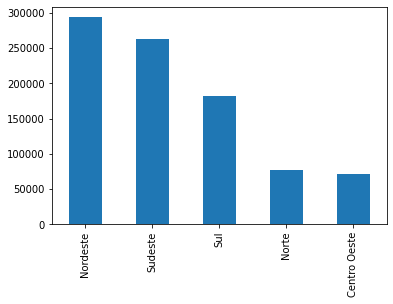

In [ ]:
df['region'].value_counts().plot(kind='bar')

Analisando a região Nordeste para ver, quais de seus estados tiveram mais numero de mortes.

* No Nordeste, o estado do **CE** foi o que mais registrou mortes.

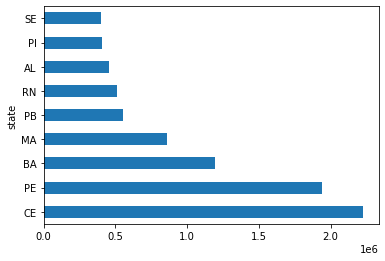

In [ ]:
nordeste = df[df['region'] == 'Nordeste']

nordeste.groupby('state')['last_available_deaths'].sum().sort_values(ascending=False).plot(kind='barh')

Na região Sudeste, o estado de **SP** foi o que registrou mais mortes.

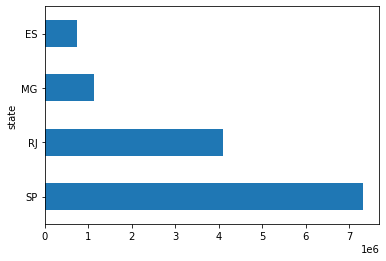

In [ ]:
sudeste = df[df['region'] == 'Sudeste']

sudeste.groupby('state')['last_available_deaths'].sum().sort_values(ascending=False).plot(kind='barh')

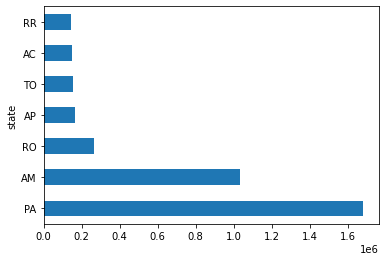

In [ ]:
norte = df[df['region'] == 'Norte']

norte.groupby('state')['last_available_deaths'].sum().sort_values(ascending=False).plot(kind='barh')

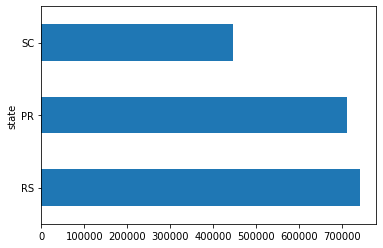

In [ ]:
sul = df[df['region'] == 'Sul']

sul.groupby('state')['last_available_deaths'].sum().sort_values(ascending=False).plot(kind='barh')

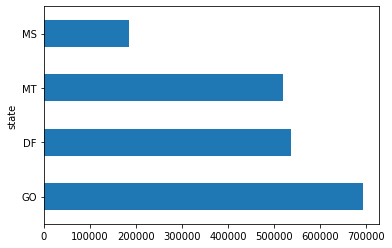

In [ ]:
centro_oeste = df[df['region'] == 'Centro Oeste']

centro_oeste.groupby('state')['last_available_deaths'].sum().sort_values(ascending=False).plot(kind='barh')

Text(0.5, 1.0, 'Casos Confirmados semanas após Feriadão de Junho/2020')

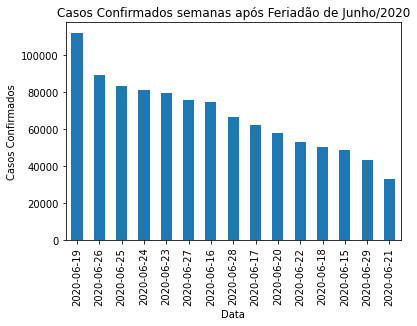

In [ ]:
#feriado corpus christi
feriado1 = df[(df['date'] > '2020-06-14') & (df['date'] < '2020-06-30')]

feriado1.groupby('date')['new_confirmed'].sum().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Data')
plt.ylabel('Casos Confirmados')   
plt.title('Casos Confirmados semanas após Feriadão de Junho/2020')    



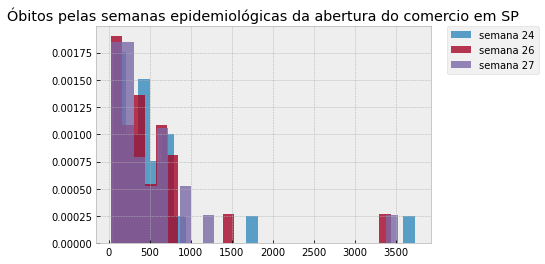

In [ ]:
plt.style.use('bmh')
plt.subplots()
df[df['epidemiological_week'] == 30].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 24')
df[df['epidemiological_week'] == 31].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 26')
df[df['epidemiological_week'] == 33].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 27')
plt.title('Óbitos pelas semanas epidemiológicas da abertura do comercio em SP')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
temp = df.groupby(['epidemiological_week', 'date'])['new_confirmed','new_deaths'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
temp = temp.melt(id_vars='date', value_vars=['new_confirmed', 'new_deaths'], 
                 var_name='Case', value_name='Count')

temp

,date,Case,Count
0,2020-02-25,new_confirmed,2
1,2020-02-26,new_confirmed,0
2,2020-02-27,new_confirmed,0
3,2020-02-28,new_confirmed,2
4,2020-02-29,new_confirmed,0
...,...,...,...
455,2020-10-19,new_deaths,578
456,2020-10-20,new_deaths,1146
457,2020-10-21,new_deaths,878
458,2020-10-22,new_deaths,775


In [ ]:
df

,state,city,date,order_for_place,is_last,epidemiological_week,estimated_population_2019,last_available_confirmed,last_available_death_rate,last_available_deaths,new_confirmed,new_deaths,region
0,SP,São Paulo,2020-02-25,1,False,9,12252023.0,1,0.0000,0,1,0,Sudeste
1,SP,NaN,2020-02-25,1,False,9,45919049.0,1,0.0000,0,1,0,Sudeste
2,SP,São Paulo,2020-02-26,2,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
3,SP,NaN,2020-02-26,2,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
4,SP,São Paulo,2020-02-27,3,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
931527,RS,NaN,2020-10-23,228,True,43,11377239.0,230944,0.0240,5554,2182,36,Sul
931528,SC,NaN,2020-10-23,226,True,43,7164788.0,243116,0.0124,3015,2072,4,Sul
931529,SE,NaN,2020-10-23,224,True,43,2298696.0,83407,0.0259,2163,268,6,Nordeste
931530,SP,NaN,2020-10-23,242,True,43,45919049.0,1083641,0.0356,38608,6702,126,Sudeste


In [ ]:
temp2 = df.groupby(['epidemiological_week'])['new_confirmed','new_deaths'].sum().reset_index()
temp2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,epidemiological_week,new_confirmed,new_deaths
0,9,4,0
1,10,33,0
2,11,231,0
3,12,1935,30
4,13,5476,183
5,14,13044,675
6,15,17739,1166
7,16,32365,2468
8,17,39230,3052
9,18,64936,4552


In [ ]:
df.rename(columns={'last_available_confirmed' : 'confirmed', 'last_available_confirmed_per_100k_inhabitants' : 'incidence',
                    'estimated_population_2019' : 'population','last_available_deaths' : 'deaths',
                    'last_available_death_rate' : 'death_rate', 'order_for_place' : 'day'}, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


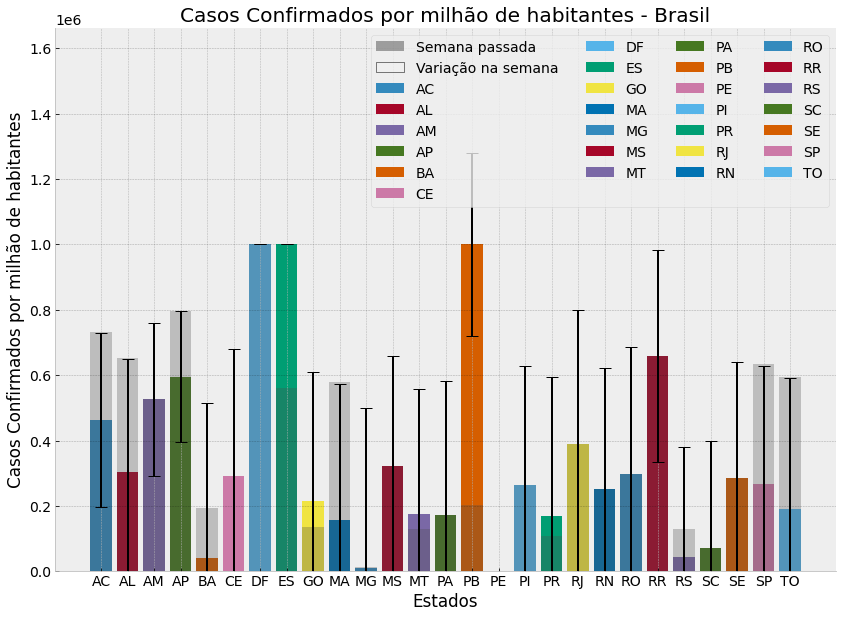

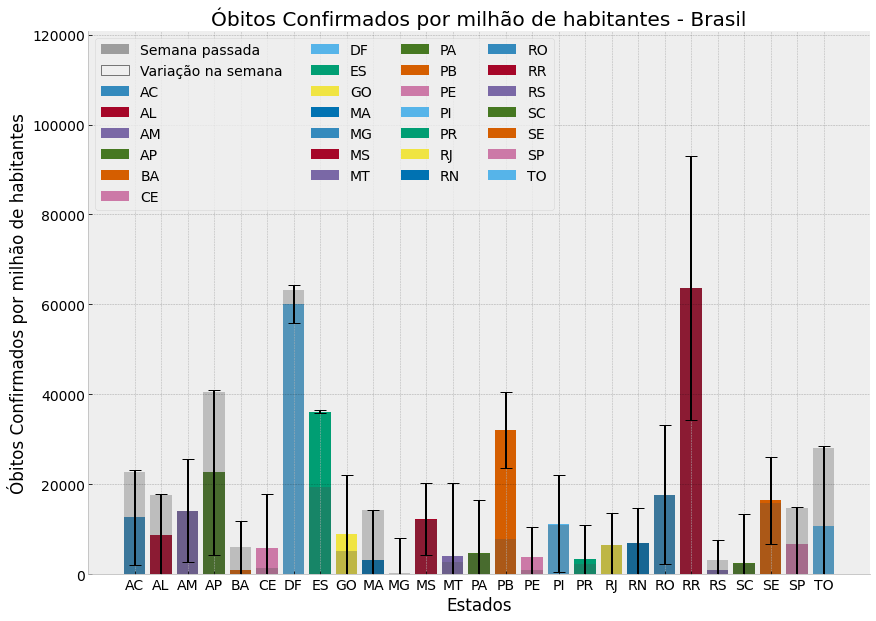

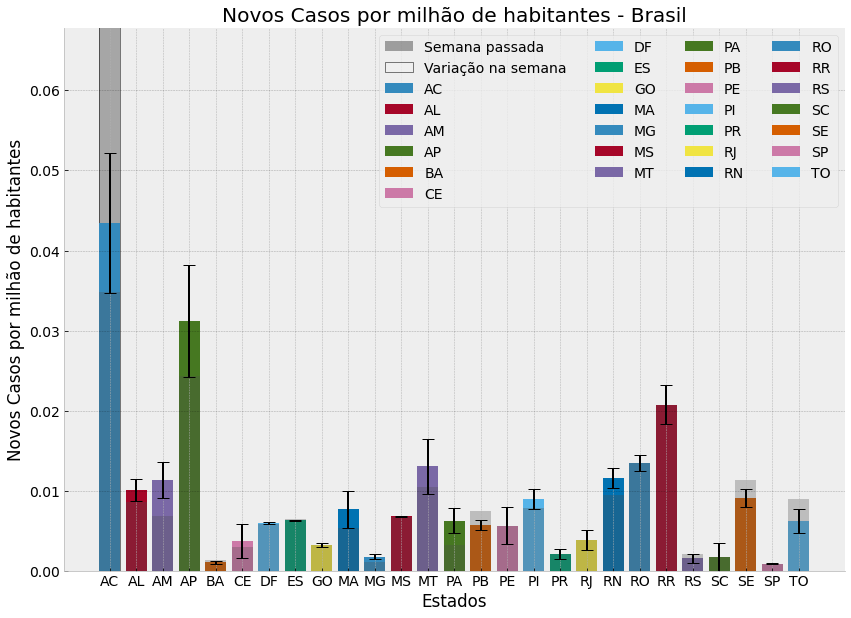

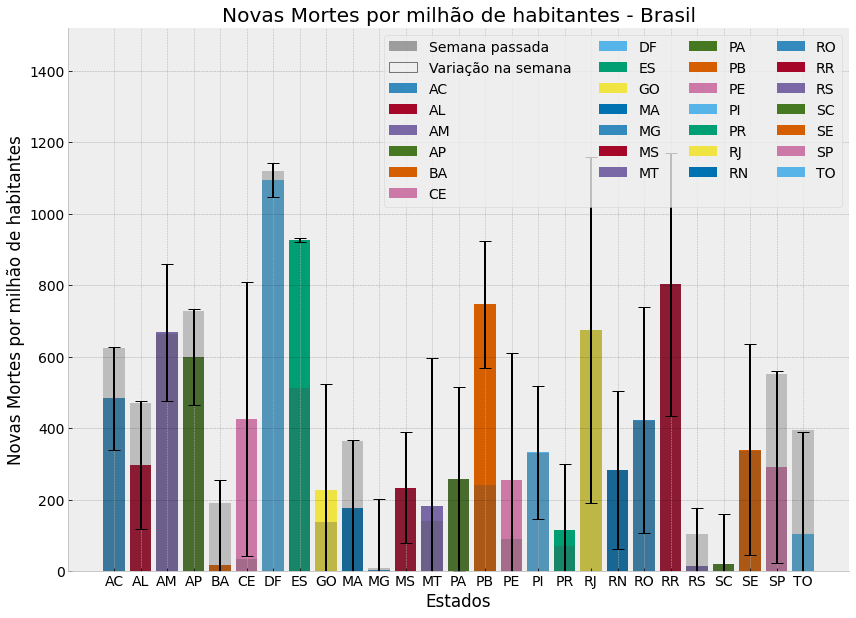

In [ ]:
plt.style.use('bmh')

label = ["Estado", "Regiao", "População", "Último Dado", "Data", "Dia", "Casos Confirmados",
         "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

for f in range(6, 10) :  
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)

    estados = list(df.loc[df['is_last'],
                                  ['state']
                                 ].sort_values('state', ascending = True)['state'].unique())

    y_max = 0
    y_pmax = [5000, 1000, 1000, 200]
        
    plt.bar(estados[0], 1, label = 'Semana passada', color = (.3, .3, .3, .5))
    plt.bar(estados[0], 1, label = 'Variação na semana', color = (1, 1, 1, 0.1), edgecolor = 'black')
    
    for e in range(27) :      
        pop = max(df.loc[(df['state'] == estados[e]) & (df['is_last']), 
                                 ['population']].loc[:, 'population'])
        
        y = np.median(df.loc[(df['state'] == estados[e]), 
                                   :].sort_values('day', ascending = True).iloc[:-1, f].tail(7))
        
        y_pop = (10 ** 6) * y / pop
        y_pop_std = (10 ** 6) * np.std(df.loc[(df['state'] == estados[e]),
                                                   :].sort_values('day', ascending = True).iloc[:-1, f].tail(7)) / pop        
        
        y_last = np.median(df.loc[(df['state'] == estados[e]), 
                                   :].sort_values('day', ascending = True).iloc[:-8, f].tail(14))
        
        y_pop_last = (10 ** 6) * y_last / pop
        y_pop_last_std = (10 ** 6) * np.std(df.loc[(df['state'] == estados[e]), 
                                                    :].sort_values('day', ascending = True).iloc[:-8, f].tail(14)) / pop
        
        if (y_pop + y_pop_std) > y_max : y_max = (y_pop + y_pop_std)
        #print(y_pop_std)
        
        ratio = y_pop / y_max
        
        if ratio < .0625 :
            plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e],  align='center', capsize = 6)
        elif (ratio >= .0625) & (ratio <= .125) :   
            plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e],  align='center', capsize = 6)
        elif (ratio >= .125) & (ratio <= .25) :
            plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e],  align='center', capsize = 6)
        elif (ratio >= .25) & (ratio <= .5) :
            plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e],  align='center', capsize = 6)
        elif (ratio >= .5) & (ratio <= .75) :
             plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e], align='center', capsize = 6)
        else  :
            plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e], align='center', capsize = 6)
        
        plt.bar(estados[e], y_pop_last, color = (.3, .3, .3, .3))
        
    plt.xlabel('Estados')       
    plt.ylim(0, y_max * 1.3)         
    plt.title(label[f] + " por milhão de habitantes - Brasil")
    plt.legend(ncol = 4)
    plt.ylabel(label[f] + " por milhão de habitantes")
    plt.savefig('graficos/' + label[f] + " 1M.png")
    plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


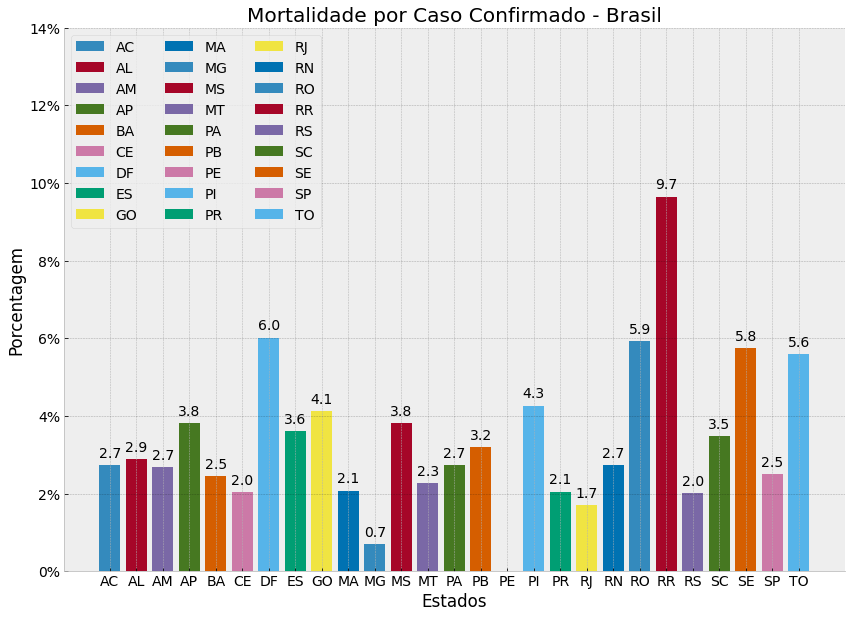

In [ ]:
plt.rc('font', size = 14)
plt.rcParams['figure.figsize'] = [14, 10]

plt.gca().spines["top"].set_visible(False)    
plt.gca().spines["right"].set_visible(False)
plt.gca().get_xaxis().tick_bottom()    
plt.gca().get_yaxis().tick_left()
plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)


estados = list(df.loc[df['is_last'],
                              ['state']
                             ].sort_values('state', ascending = True)['state'].unique())

y_max = 1

for e in range(27) :      
    y = np.median(df.loc[(df['state'] == estados[e]), 
                               :].sort_values('day', ascending = True).iloc[:-1, 7].tail(7))
    
    yc = np.median(df.loc[(df['state'] == estados[e]), 
                               :].sort_values('day', ascending = True).iloc[:-1, 6].tail(7))

    ymor = y / yc

    ratio = ymor / 0.15

    if ratio < .0625 :
        plt.bar(estados[e], ymor, label = estados[e])
    elif (ratio >= .0625) & (ratio <= .125) :   
        plt.bar(estados[e], ymor, label = estados[e])
    elif (ratio >= .125) & (ratio <= .25) :
        plt.bar(estados[e], ymor, label = estados[e])
    elif (ratio >= .25) & (ratio <= .5) :
        plt.bar(estados[e], ymor, label = estados[e])
    elif (ratio >= .5) & (ratio <= .75) :
         plt.bar(estados[e], ymor, label = estados[e])
    else  :
        plt.bar(estados[e], ymor, label = estados[e])
    
    if ymor != 0 :   
        plt.text(estados[e], ymor + .003, str(round(ymor * 100, 1)), color = 'black', 
                 fontsize = 14, horizontalalignment = 'center', verticalalignment = 'center')
    
plt.yticks(np.arange(0, .15, .02), 
           [str(x) + "%" for x in np.arange(0, 15, 2)], fontsize = 14)        
        
plt.xlabel('Estados')       
plt.ylim(0, 0.14)         
plt.title("Mortalidade por Caso Confirmado - Brasil")
plt.legend(ncol = 3)
plt.ylabel("Porcentagem")
plt.savefig("graficos/ Mortalidade.png")
plt.show()

### Renomeia as colunas para idioma pt-br

In [ ]:
df_estados = df.groupby(['city', 'date', 'state'])['new_confirmed','new_deaths'].sum().reset_index()
df_estados

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,city,date,state,new_confirmed,new_deaths
0,Abadia de Goiás,2020-05-21,GO,6,0
1,Abadia de Goiás,2020-05-28,GO,0,0
2,Abadia de Goiás,2020-05-29,GO,0,0
3,Abadia de Goiás,2020-05-30,GO,0,0
4,Abadia de Goiás,2020-05-31,GO,0,0
...,...,...,...,...,...
881348,Óleo,2020-10-19,SP,0,0
881349,Óleo,2020-10-20,SP,0,0
881350,Óleo,2020-10-21,SP,0,0
881351,Óleo,2020-10-22,SP,0,0


In [ ]:
df_estados.city.value_counts(10)

Importados/Indefinidos    0.004043
Bom Jesus                 0.000918
São Domingos              0.000807
Santa Luzia               0.000807
Bonito                    0.000734
                            ...   
Garruchos                 0.000036
Novo Tiradentes           0.000035
Pedras Altas              0.000034
Estrela Velha             0.000032
Coqueiro Baixo            0.000023
Name: city, Length: 5294, dtype: float64

In [ ]:
#Agrupando por data,semana epidemiologica por ultimos confirmados e mortos
df_agrupado = df.groupby(['epidemiological_week', 'date'])['new_confirmed', 'new_deaths'].sum().reset_index()
df_agrupado.sort_values(by='new_confirmed', ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,epidemiological_week,date,new_confirmed,new_deaths
138,30,2020-07-22,132021,2591
160,33,2020-08-13,115868,2412
146,31,2020-07-30,115448,2385
139,30,2020-07-23,114920,2627
105,25,2020-06-19,111971,2336
...,...,...,...,...
5,10,2020-03-01,0,0
4,9,2020-02-29,0,0
13,11,2020-03-09,0,0
2,9,2020-02-27,0,0


In [ ]:
temp = df.groupby(['epidemiological_week', 'date'])['new_confirmed','new_deaths'].sum().reset_index()
temp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,epidemiological_week,date,new_confirmed,new_deaths
0,9,2020-02-25,2,0
1,9,2020-02-26,0,0
2,9,2020-02-27,0,0
3,9,2020-02-28,2,0
4,9,2020-02-29,0,0
...,...,...,...,...
225,43,2020-10-19,29430,578
226,43,2020-10-20,42221,1146
227,43,2020-10-21,42500,878
228,43,2020-10-22,40025,775


In [ ]:
#função melt do pandas para remodelar o dataframe com variável e valor, para ter a quantidade de casos
temp = temp.melt(id_vars='date', value_vars=['new_confirmed', 'new_deaths'], 
                 var_name='Case', value_name='Count')
temp

,date,Case,Count
0,2020-02-25,new_confirmed,2
1,2020-02-26,new_confirmed,0
2,2020-02-27,new_confirmed,0
3,2020-02-28,new_confirmed,2
4,2020-02-29,new_confirmed,0
...,...,...,...
455,2020-10-19,new_deaths,578
456,2020-10-20,new_deaths,1146
457,2020-10-21,new_deaths,878
458,2020-10-22,new_deaths,775


### Plots das 3 semanas epidemiológicas com maiores registros de mortes

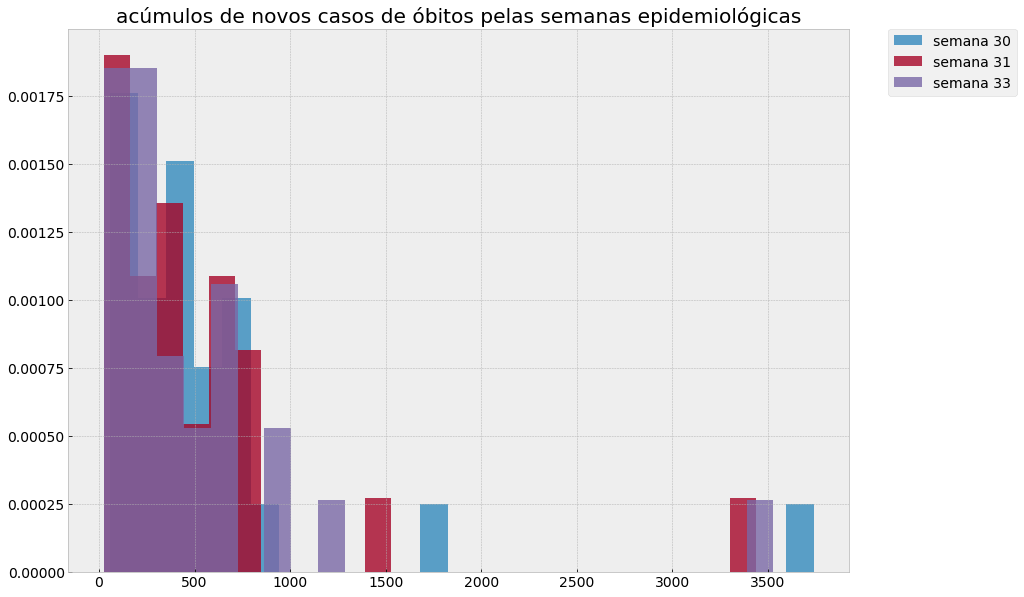

In [ ]:
plt.style.use('bmh')
plt.subplots()
df[df['epidemiological_week'] == 30].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 30')
df[df['epidemiological_week'] == 31].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 31')
df[df['epidemiological_week'] == 33].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 33')
plt.title('acúmulos de novos casos de óbitos pelas semanas epidemiológicas')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
# df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y').dt.strftime('%d-%m-%Y')

# df

In [ ]:
df

,state,city,date,day,is_last,epidemiological_week,population,confirmed,death_rate,deaths,new_confirmed,new_deaths,region
0,SP,São Paulo,2020-02-25,1,False,9,12252023.0,1,0.0000,0,1,0,Sudeste
1,SP,NaN,2020-02-25,1,False,9,45919049.0,1,0.0000,0,1,0,Sudeste
2,SP,São Paulo,2020-02-26,2,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
3,SP,NaN,2020-02-26,2,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
4,SP,São Paulo,2020-02-27,3,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
931527,RS,NaN,2020-10-23,228,True,43,11377239.0,230944,0.0240,5554,2182,36,Sul
931528,SC,NaN,2020-10-23,226,True,43,7164788.0,243116,0.0124,3015,2072,4,Sul
931529,SE,NaN,2020-10-23,224,True,43,2298696.0,83407,0.0259,2163,268,6,Nordeste
931530,SP,NaN,2020-10-23,242,True,43,45919049.0,1083641,0.0356,38608,6702,126,Sudeste


Text(0, 0.5, 'Média da Taxa de Mortalidade')

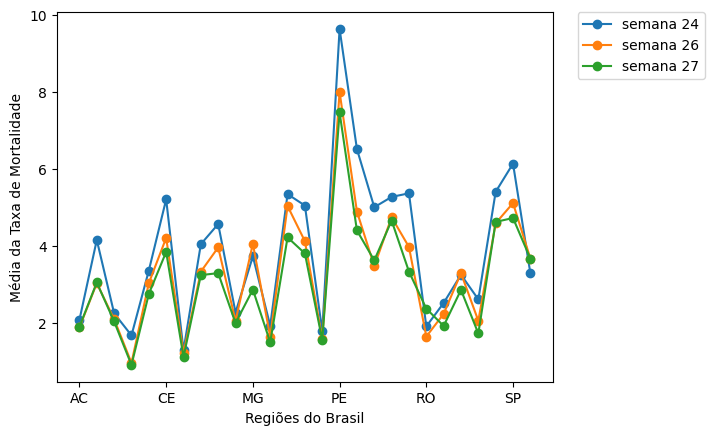

In [ ]:
#Crescimendo da taxa de mortalidade entre os estados comparado as semanas epidemiológicas.

plt.style.use('default')
(df[df['epidemiological_week']==24].groupby('state')['death_rate'].mean()*100).plot(marker='o',label='semana 24')
(df[df['epidemiological_week']==26].groupby('state')['death_rate'].mean()*100).plot(marker='o',label='semana 26')
(df[df['epidemiological_week']==27].groupby('state')['death_rate'].mean()*100).plot(marker='o',label='semana 27')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Regiões do Brasil')
plt.ylabel('Média da Taxa de Mortalidade')


Text(0.5, 1.0, 'Casos confirmados nas cidades de São Paulo após reabertura do comercio')

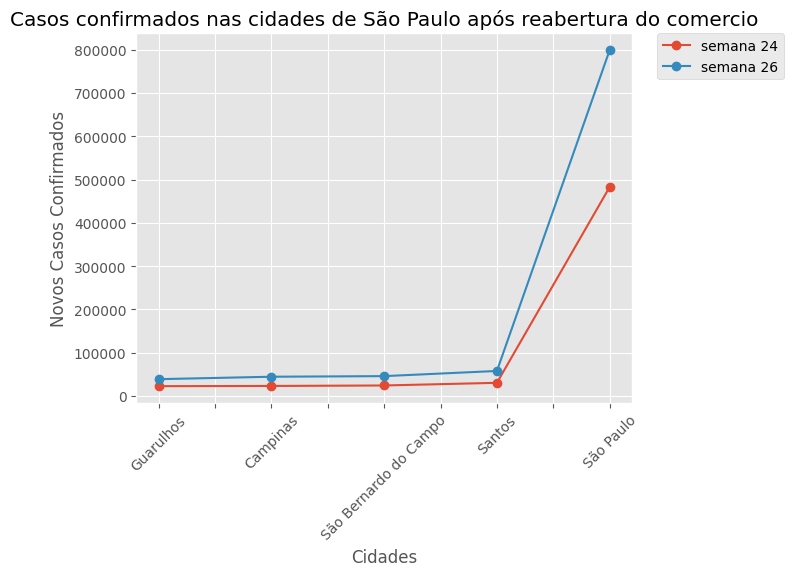

In [ ]:
plt.style.use('ggplot')
df[(df['state']=='SP')&(df['epidemiological_week']==24)].groupby('city')['confirmed'].sum().sort_values().tail(5).plot(marker='o',label='semana 24')
df[(df['state']=='SP')&(df['epidemiological_week']==26)].groupby('city')['confirmed'].sum().sort_values().tail(5).plot(marker='o',label='semana 26')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=45)
plt.xlabel('Cidades')
plt.ylabel('Novos Casos Confirmados')
plt.title('Casos confirmados nas cidades de São Paulo após reabertura do comercio')

Text(0.5, 0, 'Média de novos casos por Região')

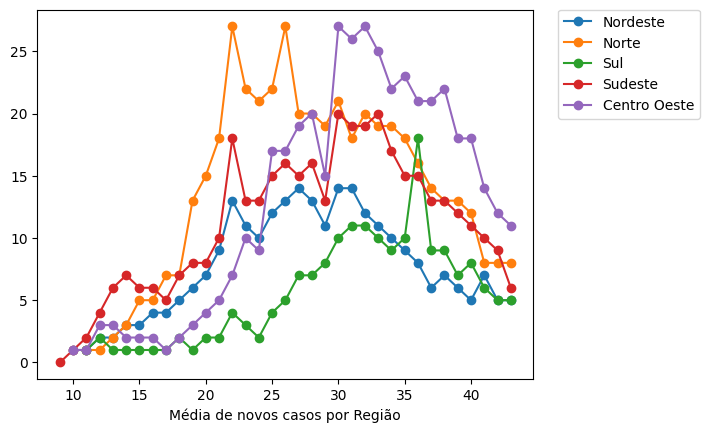

In [ ]:
#Gráfico demonstrativo de médias da evolução de novos casos de corona nos estados.

plt.style.use('default')
df[df['region'] == 'Nordeste'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Nordeste')
df[df['region'] == 'Norte'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Norte')
df[df['region'] == 'Sul'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Sul')
df[df['region'] == 'Sudeste'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Sudeste')
df[df['region'] == 'Centro Oeste'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Centro Oeste')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Média de novos casos por Região')

### Renomeando colunas

In [ ]:
# #renomeando nome de colunas para pt-br
# df = df['city','state','region','data','is_last','order_for_place','estimated_population_2019','epidemiological_week','last_available_death_rate','last_available_confirmed','last_available_deaths','new_confirmed','new_deaths']
# df = df.rename(columns = {
#                           'state': 'estado',
#                           'city':'cidade',
#                           'region':'regiao',
#                           'estimated_population_2019': 'populacao',
#                           'order_for_place':'dia',
#                           'date':'data',
#                           'epidemiological_week':'semana_epidemiologica',                          
#                           'last_available_confirmed':'casos_confirmados',
#                           'last_available_deaths':'mortes_confirmadas',
#                           'new_confirmed':'novos_casos',
#                           'new_deaths':'novos_obitos',
#                           'last_available_death_rate':'mortalidade',
#                           })

# df

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 <a list of 11 Text major ticklabel objects>)

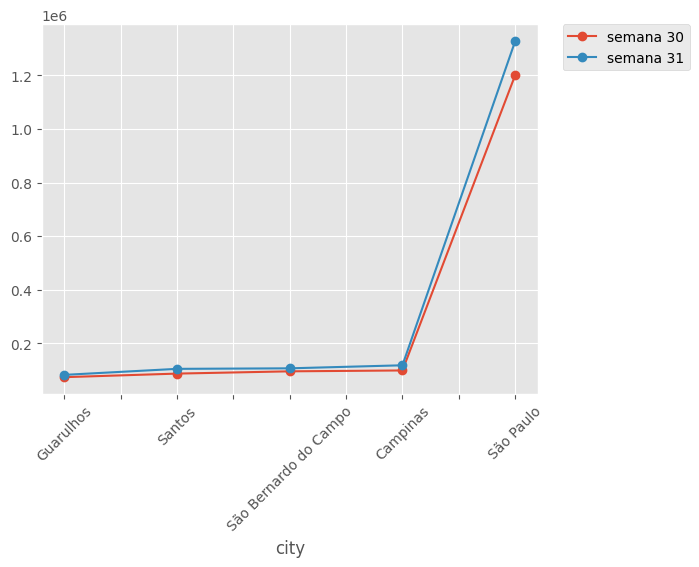

In [ ]:
plt.style.use('ggplot')
df[(df['state']=='SP')&(df['epidemiological_week']==30)].groupby('city')['confirmed'].sum().sort_values().tail(5).plot(marker='o',label='semana 30')
df[(df['state']=='SP')&(df['epidemiological_week']==31)].groupby('city')['confirmed'].sum().sort_values().tail(5).plot(marker='o',label='semana 31')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=45)

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 <a list of 11 Text major ticklabel objects>)

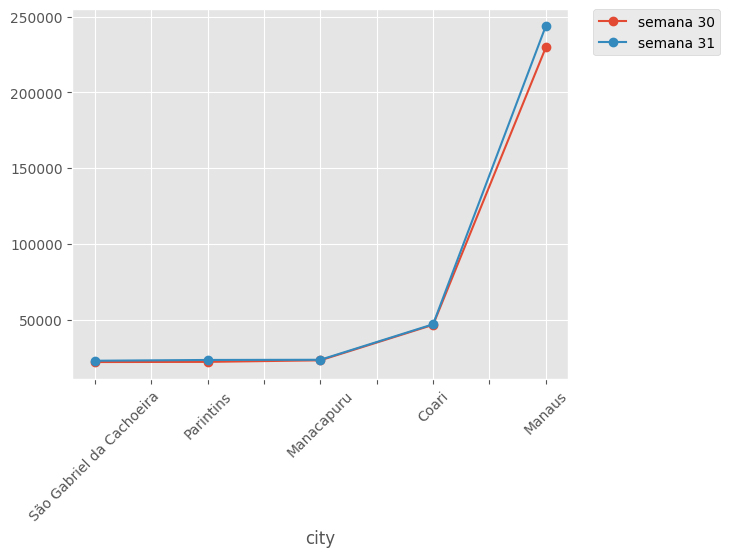

In [ ]:
plt.style.use('ggplot')
df[(df['state']=='AM')&(df['epidemiological_week']==30)].groupby('city')['confirmed'].sum().sort_values().tail(5).plot(marker='o',label='semana 30')
df[(df['state']=='AM')&(df['epidemiological_week']==31)].groupby('city')['confirmed'].sum().sort_values().tail(5).plot(marker='o',label='semana 31')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=45)

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 <a list of 11 Text major ticklabel objects>)

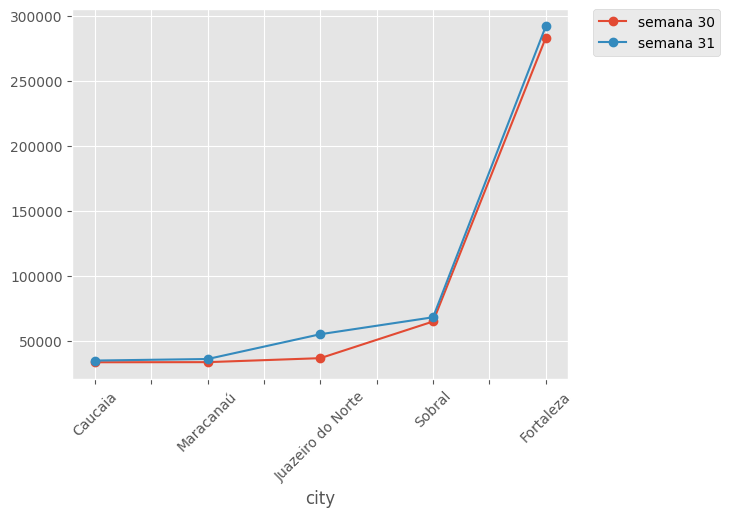

In [ ]:
plt.style.use('ggplot')
df[(df['state']=='CE')&(df['epidemiological_week']==30)].groupby('city')['confirmed'].sum().sort_values().tail(5).plot(marker='o',label='semana 30')
df[(df['state']=='CE')&(df['epidemiological_week']==31)].groupby('city')['confirmed'].sum().sort_values().tail(5).plot(marker='o',label='semana 31')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=45)

In [ ]:
#contando os valores ausentes/nulos do dataset filtrado
df.isnull().sum()

state                      0
city                    5755
date                       0
day                        0
is_last                    0
epidemiological_week       0
population              3563
confirmed                  0
death_rate                 0
deaths                     0
new_confirmed              0
new_deaths                 0
region                     0
dtype: int64

In [ ]:
#quantidade de estados do Brasil no dataset
df['state'].nunique()

27

In [ ]:
# #quantidade de cidades do Brasil no dataset
df['city'].nunique()

5294

### Aplicando filtro para não contabilizar os dados dos feriados que tiveram durante a pandemia

Text(0.5, 0, 'média de novos casos')

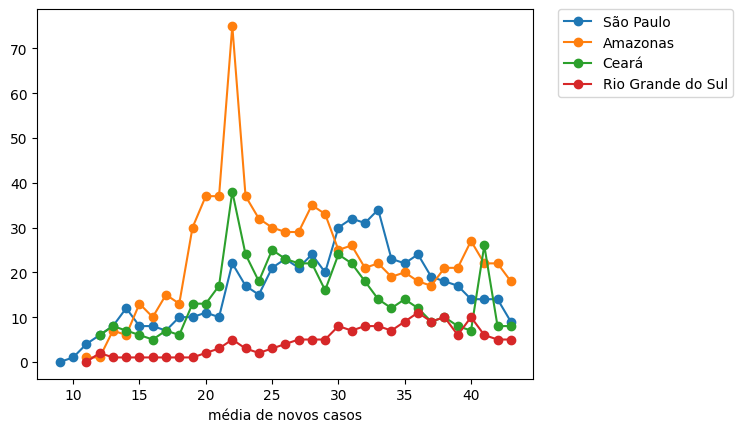

In [ ]:
plt.style.use('default')
df[df['state'] == 'SP'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='São Paulo')
df[df['state'] == 'AM'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Amazonas')
df[df['state'] == 'CE'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Ceará')
df[df['state'] == 'RS'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Rio Grande do Sul')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('média de novos casos')

Text(0.5, 1.0, 'Média de novos casos por região')

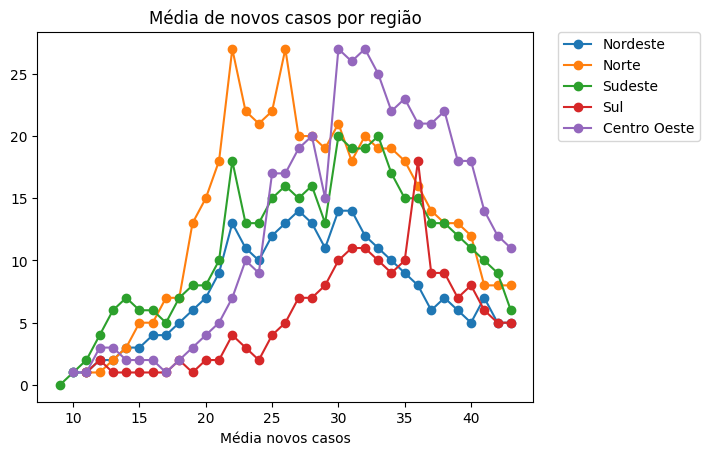

In [ ]:
plt.style.use('default')
df[df['region'] == 'Nordeste'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Nordeste')
df[df['region'] == 'Norte'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Norte')
df[df['region'] == 'Sudeste'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Sudeste')
df[df['region'] == 'Sul'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Sul')
df[df['region'] == 'Centro Oeste'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Centro Oeste')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Média novos casos')
plt.title('Média de novos casos por região')

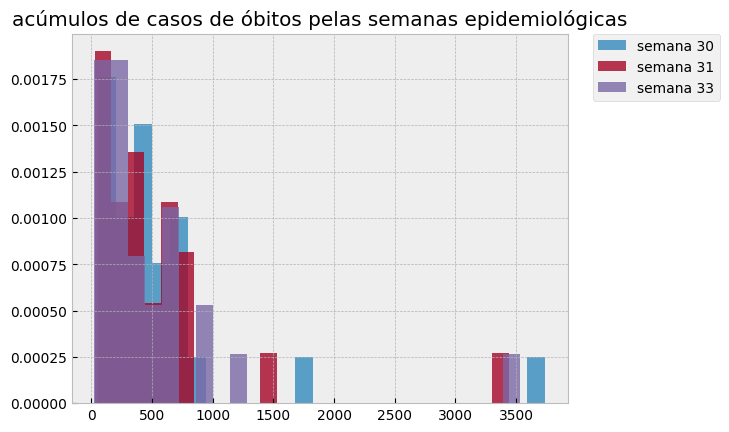

In [ ]:
plt.style.use('bmh')
plt.subplots()
df[df['epidemiological_week'] == 30].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 30')
df[df['epidemiological_week'] == 31].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 31')
df[df['epidemiological_week'] == 33].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 33')
plt.title('acúmulos de casos de óbitos pelas semanas epidemiológicas')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

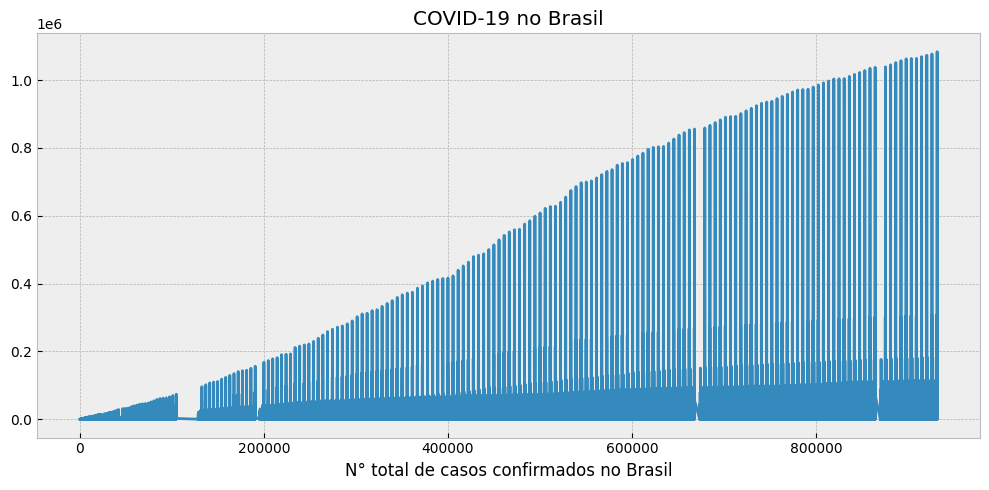

In [ ]:

fig, ax = plt.subplots(figsize = (10,5))

ax.plot('confirmed', data = df)
ax.set_title('COVID-19 no Brasil')
ax.set_xlabel('N° total de casos confirmados no Brasil')
plt.tight_layout()

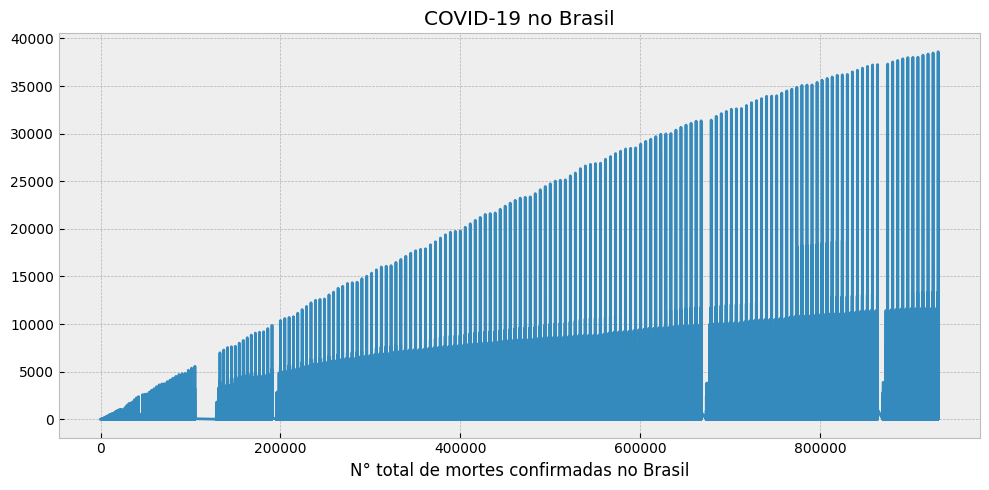

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot('deaths', data = df)
ax.set_title('COVID-19 no Brasil')
ax.set_xlabel('N° total de mortes confirmadas no Brasil')
plt.tight_layout()

### Top 5 estados brasileiros com mais casos até o dia 19-10-2020 (ultimo dia que o dataset pegou durante a analise)

Text(0.5, 0, 'Estados')

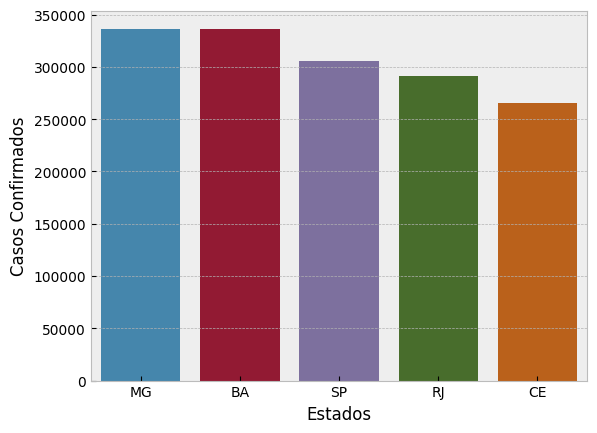

In [ ]:
top5_confirmados_estados_br = df.loc[df.date == '2020-10-19', ['state', 'confirmed']] \
    .sort_values(by = 'confirmed', ascending = False)[1:6]


sns.barplot(x ='state', y ='confirmed', data=top5_confirmados_estados_br);
plt.ylabel('Casos Confirmados')
plt.xlabel('Estados')

# top5_confirmados_estados_br

Text(0.5, 0, 'Estados')

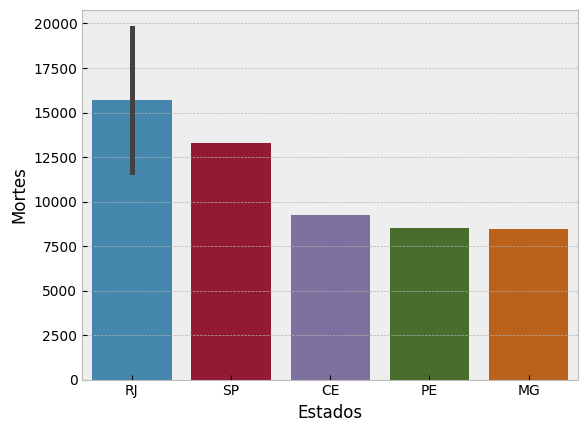

In [ ]:
top5_mortes_estados_br = df.loc[df.date == '2020-10-19', ['state', 'deaths']] \
    .sort_values(by = 'deaths', ascending = False)[1:7]

sns.barplot(x = 'state', y = 'deaths', data = top5_mortes_estados_br);
plt.ylabel('Mortes')
plt.xlabel('Estados')

In [ ]:
df.groupby('state')['deaths'].count()

state
AC      3958
AL     17062
AM     11203
AP      3042
BA     65607
CE     33035
DF       638
ES     14483
GO     36513
MA     36124
MG    124663
MS     12219
MT     21661
PA     25355
PB     35232
PE     32436
PI     33861
PR     61222
RJ     17514
RN     27481
RO      8827
RR      3041
RS     72967
SC     47835
SE     12660
SP    106742
TO     21727
Name: deaths, dtype: int64

In [ ]:
#filtrando os dados da cidade de São Paulo
df_sp = df[df['state']=='SP']
df_sp = df_sp.sort_values(by=['date'], ascending=False)

df_sp

,state,city,date,day,is_last,epidemiological_week,population,confirmed,death_rate,deaths,new_confirmed,new_deaths,region
931530,SP,NaN,2020-10-23,242,True,43,45919049.0,1083641,0.0356,38608,6702,126,Sudeste
930922,SP,Guariba,2020-10-23,178,False,43,40105.0,1179,0.0280,33,0,0,Sudeste
930940,SP,Ibiúna,2020-10-23,200,False,43,78878.0,441,0.0590,26,0,0,Sudeste
930939,SP,Ibitinga,2020-10-23,177,False,43,60033.0,1581,0.0266,42,0,0,Sudeste
930938,SP,Ibirá,2020-10-23,196,False,43,12393.0,387,0.0233,9,0,0,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,SP,NaN,2020-02-27,3,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
2,SP,São Paulo,2020-02-26,2,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
3,SP,NaN,2020-02-26,2,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
1,SP,NaN,2020-02-25,1,False,9,45919049.0,1,0.0000,0,1,0,Sudeste


In [ ]:
#filtrando os dados apenas da cidade de Campinas - SP
df_ma = df[df['state']=='AM']
df_ma = df_ma.sort_values(by=['date'], ascending=False)

df_ma

,state,city,date,day,is_last,epidemiological_week,population,confirmed,death_rate,deaths,new_confirmed,new_deaths,region
931507,AM,NaN,2020-10-23,225,True,43,4144597.0,156196,0.0283,4426,966,30,Norte
926077,AM,Japurá,2020-10-23,166,False,43,2755.0,456,0.0022,1,0,0,Norte
926075,AM,Itamarati,2020-10-23,164,False,43,7851.0,581,0.0103,6,0,0,Norte
926074,AM,Itacoatiara,2020-10-23,209,False,43,101337.0,2338,0.0317,74,0,0,Norte
926073,AM,Iranduba,2020-10-23,202,False,43,48296.0,2147,0.0275,59,0,0,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,AM,NaN,2020-03-15,3,False,12,4144597.0,2,0.0000,0,0,0,Norte
182,AM,Manaus,2020-03-14,2,False,11,2182763.0,2,0.0000,0,0,0,Norte
213,AM,NaN,2020-03-14,2,False,11,4144597.0,2,0.0000,0,0,0,Norte
167,AM,NaN,2020-03-13,1,False,11,4144597.0,2,0.0000,0,2,0,Norte


Aplicando um filtro para visualizar os dados que indiquem numeros positivos.
Foi visto que há valores negativos no dataset, ex: -1

In [ ]:
df_sp = df_sp[(df_sp['new_deaths'] >= 0) & (df_sp['new_confirmed'] >= 0) & (df_sp['deaths'] >= 0) & (df_sp['confirmed'] >= 0)] 
df_sp
# df_sp.sample(5)

,state,city,date,day,is_last,epidemiological_week,population,confirmed,death_rate,deaths,new_confirmed,new_deaths,region
931530,SP,NaN,2020-10-23,242,True,43,45919049.0,1083641,0.0356,38608,6702,126,Sudeste
930922,SP,Guariba,2020-10-23,178,False,43,40105.0,1179,0.0280,33,0,0,Sudeste
930940,SP,Ibiúna,2020-10-23,200,False,43,78878.0,441,0.0590,26,0,0,Sudeste
930939,SP,Ibitinga,2020-10-23,177,False,43,60033.0,1581,0.0266,42,0,0,Sudeste
930938,SP,Ibirá,2020-10-23,196,False,43,12393.0,387,0.0233,9,0,0,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,SP,NaN,2020-02-27,3,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
2,SP,São Paulo,2020-02-26,2,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
3,SP,NaN,2020-02-26,2,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
1,SP,NaN,2020-02-25,1,False,9,45919049.0,1,0.0000,0,1,0,Sudeste


In [ ]:
#filtrando os dados apenas do estado do Céara - CE
df_ce = df[df['state']=='CE']
df_ce = df_ce.sort_values(by=['date'], ascending=False)

df_ce

,state,city,date,day,is_last,epidemiological_week,population,confirmed,death_rate,deaths,new_confirmed,new_deaths,region
931510,CE,NaN,2020-10-23,222,True,43,9132078.0,269255,0.0343,9245,910,2,Nordeste
926600,CE,Fortaleza,2020-10-23,222,False,43,2669342.0,54301,0.0717,3894,0,0,Nordeste
926609,CE,Guaraciaba do Norte,2020-10-23,201,False,43,40642.0,811,0.0185,15,0,0,Nordeste
926608,CE,Guaiúba,2020-10-23,190,False,43,26064.0,311,0.0868,27,0,0,Nordeste
926607,CE,Groaíras,2020-10-23,189,False,43,11068.0,798,0.0175,14,0,0,Nordeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,CE,Fortaleza,2020-03-17,2,False,12,2669342.0,9,0.0000,0,1,0,Nordeste
344,CE,Aquiraz,2020-03-17,2,False,12,80271.0,1,0.0000,0,0,0,Nordeste
322,CE,NaN,2020-03-16,1,False,12,9132078.0,9,0.0000,0,9,0,Nordeste
284,CE,Fortaleza,2020-03-16,1,False,12,2669342.0,8,0.0000,0,8,0,Nordeste


In [ ]:
# mask = ((df_fortaleza['data'] >= '2020-05-22') & (df_fortaleza['data'] <= '2020-05-27'))
# df_fortaleza = df_fortaleza.drop(mask.index)

# df_fortaleza

In [ ]:
# df_fortaleza.drop(df_fortaleza[(df_fortaleza.data >= '2020-05-22') & (df_fortaleza['data'] <= '2020-05-27')].index, inplace=True)
# filtro_feriados = df_fortaleza[(df_fortaleza.data >= '2020-05-22') & (df_fortaleza.data <= '2020-05-27')]
# filtro_feriados

In [ ]:
df.dropna(subset=['state'], inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_deaths_race = df.loc[(df.deaths > 0)]
df_deaths_race

,state,city,date,day,is_last,epidemiological_week,population,confirmed,death_rate,deaths,new_confirmed,new_deaths,region
389,SP,São Paulo,2020-03-17,22,False,12,12252023.0,156,0.0064,1,11,1,Sudeste
408,SP,NaN,2020-03-17,22,False,12,45919049.0,164,0.0061,1,12,1,Sudeste
480,SP,São Paulo,2020-03-18,23,False,12,12252023.0,214,0.0140,3,58,2,Sudeste
501,SP,NaN,2020-03-18,23,False,12,45919049.0,240,0.0125,3,76,2,Sudeste
553,RJ,Miguel Pereira,2020-03-19,1,False,12,25538.0,1,1.0000,1,1,1,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
931527,RS,NaN,2020-10-23,228,True,43,11377239.0,230944,0.0240,5554,2182,36,Sul
931528,SC,NaN,2020-10-23,226,True,43,7164788.0,243116,0.0124,3015,2072,4,Sul
931529,SE,NaN,2020-10-23,224,True,43,2298696.0,83407,0.0259,2163,268,6,Nordeste
931530,SP,NaN,2020-10-23,242,True,43,45919049.0,1083641,0.0356,38608,6702,126,Sudeste


In [ ]:
df_cases_race = df.loc[(df.confirmed > 0)]
df_cases_race

,state,city,date,day,is_last,epidemiological_week,population,confirmed,death_rate,deaths,new_confirmed,new_deaths,region
0,SP,São Paulo,2020-02-25,1,False,9,12252023.0,1,0.0000,0,1,0,Sudeste
1,SP,NaN,2020-02-25,1,False,9,45919049.0,1,0.0000,0,1,0,Sudeste
2,SP,São Paulo,2020-02-26,2,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
3,SP,NaN,2020-02-26,2,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
4,SP,São Paulo,2020-02-27,3,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
931527,RS,NaN,2020-10-23,228,True,43,11377239.0,230944,0.0240,5554,2182,36,Sul
931528,SC,NaN,2020-10-23,226,True,43,7164788.0,243116,0.0124,3015,2072,4,Sul
931529,SE,NaN,2020-10-23,224,True,43,2298696.0,83407,0.0259,2163,268,6,Nordeste
931530,SP,NaN,2020-10-23,242,True,43,45919049.0,1083641,0.0356,38608,6702,126,Sudeste


In [ ]:
df_deaths_race = pd.DataFrame(df_deaths_race.groupby(['state', 'date']).sum()['deaths']).unstack().T.droplevel(level=0)
df_deaths_race

state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
2020-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN
2020-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
2020-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN
2020-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-19,1358.0,4364.0,8682.0,1468.0,14684.0,18434.0,7122.0,7220.0,10864.0,7878.0,16906.0,3024.0,5936.0,13372.0,6002.0,16980.0,4608.0,9673.0,39540.0,4970.0,2854.0,1352.0,10776.0,5952.0,4278.0,76055.0,2057.0
2020-10-20,1361.0,4374.0,8726.0,1468.0,14726.0,18454.0,7150.0,7232.0,10932.0,7898.0,16966.0,3030.0,5948.0,13380.0,6020.0,17010.0,4628.0,9735.0,39606.0,4973.0,2856.0,1355.0,10904.0,5982.0,4284.0,76492.0,2065.0
2020-10-21,1364.0,4384.0,8734.0,1470.0,14768.0,18486.0,7174.0,7247.0,10982.0,7920.0,17037.0,3036.0,5962.0,13394.0,6040.0,17038.0,4644.0,9771.0,39715.0,4975.0,2858.0,1356.0,10964.0,5996.0,4302.0,76742.0,2074.0
